# Week 3 Day 1. Lab 

Strictly speaking there is no lab for today. However, I wanted to share this code with you. Notice that it will collect all the Springfields in the USA. It uses  a number of interesting operations including a spatial join in order to determine the state that includes the specific Springfield highlighted on a map. I have left one optimisation for you to consider. 

The Springfields are all within the continental United States. When we view this map with Alaska, Hawaii, and Puerto Rico, this makes the continental US very small and cramped. How might we improve this figure? One way, drawing on the walkthrough, would be to crop the boundaries of the map. Another way would be to exclude these areas from the original shape file using `states_gdf = states_gdf[~states_gdf['STUSPS'].isin(['AK', 'HI', 'PR'])]`. 

- Q1. Where should we add this in the code so that it filters? Hint: it must be done in two places: `join_springfields_to_states` and `plot_springfields`. 

Also, notice that this code is a bit suboptimal in that it uses springfield_gdf, rather than a more generic "cities" within the methods. 

- Q2. How would you refactor this code so that it is not so tightly bound to "Springfield"? 
- Q3. Once refactored, what of this code would you place in a `*.py` file for utilities and what would you keep in the notebook? 

First run the code to get the map as is. It's two cells. The first is all the helper methods and the second just runs the code.


In [1]:
import pandas as pd
import geopandas as gpd
import requests
from shapely.geometry import Point
import re
import os
import matplotlib.pyplot as plt

def get_disambiguation_content():
    """
    Fetch the content of the Springfield disambiguation page using the Wikipedia API
    """
    base_url = "https://en.wikipedia.org/w/api.php"
    
    # First, get the wiki text content
    params = {
        "action": "parse",
        "page": "Springfield",
        "prop": "wikitext",
        "format": "json"
    }
    
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise exception for bad status codes
        data = response.json()
        
        if 'parse' in data and 'wikitext' in data['parse']:
            return data['parse']['wikitext']['*']
        else:
            raise ValueError("Unexpected API response structure")
            
    except requests.RequestException as e:
        print(f"Error fetching disambiguation page: {e}")
        return None

def parse_us_springfields_from_wikitext(content):
    """
    Parse US Springfield locations from the Wikipedia wikitext content.
    Returns a list of Springfield locations with their state information.
    """
    springfields = []
    in_us_section = False
    
    # Split content into lines
    lines = content.split('\n')
    
    for line in lines:
        # Check for US section start
        if "=== United States ===" in line:
            in_us_section = True
            continue
        # Check for next section (end of US section)
        elif in_us_section and line.startswith('==='):
            break
        
        # Process lines in US section
        if in_us_section and line.strip().startswith('*'):
            # Clean up the line and extract the link
            match = re.search(r'\[\[([^\]]+)\]\]', line)
            if match:
                entry = match.group(1)
                
                # Skip entries we don't want
                # if any(skip in entry for skip in ['metropolitan area', 'Township', 'CDP', 'disambiguation']):
                    # continue
                
                # Handle cases where link text differs from display text
                if '|' in entry:
                    entry = entry.split('|')[0]
                
                # Extract city and state
                if ',' in entry:
                    location, state_info = entry.split(',', 1)
                    state_info = state_info.strip()
                    
                    # Handle cases with additional info in parentheses
                    if '(' in state_info:
                        state_info = state_info.split('(')[0].strip()
                    
                    springfields.append({
                        'title': entry,
                        'city': location,
                        'state': state_info
                    })
    
    return springfields

def get_coordinates_batch(springfields):
    """
    Get coordinates for a list of Springfield locations using batch requests.
    Handles both coordinate properties and coordinate templates.
    """
    base_url = "https://en.wikipedia.org/w/api.php"
    results = []
    
    # Process in batches of 50
    batch_size = 50
    for i in range(0, len(springfields), batch_size):
        batch = springfields[i:i + batch_size]
        titles = [item['title'] for item in batch]
        
        # First try to get coordinates from properties
        params = {
            "action": "query",
            "titles": "|".join(titles),
            "prop": "coordinates|info|revisions",
            "inprop": "url",
            "rvprop": "content",
            "format": "json"
        }
        
        try:
            response = requests.get(base_url, params=params)
            response.raise_for_status()
            data = response.json()
            
            if 'query' in data and 'pages' in data['query']:
                for page_id, page in data['query']['pages'].items():
                    original = next((s for s in batch if s['title'] == page['title']), None)
                    if not original:
                        continue
                        
                    coordinates = None
                    
                    # Try to get coordinates from properties first
                    if 'coordinates' in page:
                        coords = page['coordinates'][0]
                        coordinates = {
                            'lat': coords['lat'],
                            'lon': coords['lon']
                        }
                    
                    # If no coordinates in properties, try to parse from content
                    elif 'revisions' in page and page['revisions']:
                        content = page['revisions'][0]['*']
                        coord_match = re.search(r'{{coord\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)\|([^|}]+)', content, re.IGNORECASE)
                        
                        if coord_match:
                            lat_deg, lat_min, lat_sec, lat_dir, lon_deg, lon_min, lon_sec, lon_dir = coord_match.groups()
                            try:
                                lat = float(lat_deg) + float(lat_min)/60 + float(lat_sec)/3600
                                lon = float(lon_deg) + float(lon_min)/60 + float(lon_sec)/3600
                                
                                if lat_dir.upper() == 'S':
                                    lat = -lat
                                if lon_dir.upper() == 'W':
                                    lon = -lon
                                    
                                coordinates = {
                                    'lat': lat,
                                    'lon': lon
                                }
                            except ValueError:
                                continue
                    
                    if coordinates:
                        results.append({
                            'title': page['title'],
                            'city': original['city'],
                            'state': original['state'],
                            'latitude': coordinates['lat'],
                            'longitude': coordinates['lon'],
                            'url': page.get('canonicalurl', '')
                        })
                            
        except requests.RequestException as e:
            print(f"Error in batch coordinate request: {e}")
            continue
    
    return pd.DataFrame(results)

def create_springfields_geodataframe():
    """
    Main function to create a GeoDataFrame of US Springfields
    """
    # Get disambiguation page content
    print("Fetching Springfield disambiguation page...")
    content = get_disambiguation_content()
    
    if content is None:
        raise ValueError("Failed to fetch disambiguation page content")
    
    # Parse US Springfields
    print("Parsing Springfield locations...")
    springfields = parse_us_springfields_from_wikitext(content)
    print(f"Found {len(springfields)} Springfield locations in US")
    
    # Get coordinates
    print("Fetching coordinates...")
    springfields_df = get_coordinates_batch(springfields)
    print(f"Successfully retrieved coordinates for {len(springfields_df)} locations")
    
    # Create GeoDataFrame
    geometry = [Point(xy) for xy in zip(springfields_df['longitude'], springfields_df['latitude'])]
    springfields_gdf = gpd.GeoDataFrame(springfields_df, geometry=geometry, crs="EPSG:4326")
    
    return springfields_gdf

def main():
    try:
        # Create GeoDataFrame
        springfields_gdf = create_springfields_geodataframe()
        
        # Display results
        print("\nSpringfield locations with coordinates:")
        print(springfields_gdf[['city', 'state', 'latitude', 'longitude']])
        
        # Optionally save to file
        springfields_gdf.to_file("springfields.geojson", driver='GeoJSON')
        
        return springfields_gdf
        
    except Exception as e:
        print(f"Error in main execution: {e}")
        return None

def join_springfields_to_states(springfields_gdf):
    """
    Perform spatial join between Springfields and US states shapefile,
    handling column name conflicts properly
    """
    # Download and prepare US states shapefile
    url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"
    
    if not os.path.exists('data'):
        os.makedirs('data')
    
    zip_path = "data/us_states.zip"
    if not os.path.exists(zip_path):
        print("Downloading US states data...")
        response = requests.get(url)
        with open(zip_path, 'wb') as f:
            f.write(response.content)
    
    # Read states shapefile
    states_gdf = gpd.read_file(f"zip://{zip_path}")
    states_gdf = states_gdf.to_crs(springfields_gdf.crs)
        
    # Rename columns in states_gdf to avoid conflicts
    states_gdf = states_gdf.rename(columns={
        'NAME': 'state_name',
        'STUSPS': 'state_abbrev'
    })
    
    
    # Before joining, rename original state column if it exists
    if 'state' in springfields_gdf.columns:
        springfields_gdf = springfields_gdf.rename(columns={'state': 'state_from_wiki'})
    
    # Perform spatial join
    joined = gpd.sjoin(
        springfields_gdf,
        states_gdf[['state_name', 'state_abbrev', 'geometry']],
        how='left',
        predicate='within'
    )
    
    # Validate and clean up the results
    joined['state_match'] = joined.apply(
        lambda x: x['state_from_wiki'].strip() == x['state_name'].strip() 
        if pd.notnull(x['state_from_wiki']) and pd.notnull(x['state_name']) 
        else False,
        axis=1
    )
    
    # Print any mismatches for verification
    mismatches = joined[~joined['state_match']]
    if not mismatches.empty:
        print("\nFound state name mismatches:")
        print(mismatches[['title', 'state_from_wiki', 'state_name', 'state_abbrev']])
    
    return joined

def plot_springfields(joined_gdf, save_path=None):
    """
    Create a map of Springfields with state highlighting
    """
    # Download states shapefile if not done already
    url = "https://www2.census.gov/geo/tiger/GENZ2020/shp/cb_2020_us_state_20m.zip"
    zip_path = "data/us_states.zip"
    states_gdf = gpd.read_file(f"zip://{zip_path}")

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plot all states in light gray
    states_gdf.plot(ax=ax, color='lightgray', edgecolor='white')
    
    # Get unique states that have Springfields
    states_with_springfields = joined_gdf['state_name'].unique()
    
    # Highlight states with Springfields    
    states_gdf[states_gdf['NAME'].isin(states_with_springfields)].plot(
        ax=ax, color='lightblue', edgecolor='white'
    )
    
    # Plot Springfield points
    joined_gdf.plot(ax=ax, color='red', markersize=50)
    
    # Add labels for each Springfield
    for idx, row in joined_gdf.iterrows():
        ax.annotate(
            f"{row['city']}, {row['state_abbrev']}",
            xy=(row.geometry.x, row.geometry.y),
            xytext=(5, 5),
            textcoords="offset points",
            fontsize=8,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.7)
        )
    
    ax.set_title('US Cities Named Springfield', fontsize=14)
    plt.axis('off')
    
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Map saved to {save_path}")
    
    return fig, ax

def analyze_springfield_distribution(joined_gdf):
    """
    Analyze the distribution of Springfields across states
    """
    # Count Springfields per state
    state_counts = joined_gdf.groupby(['state_name', 'state_abbrev']).size().reset_index(name='count')
    state_counts = state_counts.sort_values('count', ascending=False)
    
    print("\nSpringfield Distribution by State:")
    print(state_counts)
    
    return state_counts



Fetching Springfield disambiguation page...
Parsing Springfield locations...
Found 50 Springfield locations in US
Fetching coordinates...
Successfully retrieved coordinates for 40 locations

Found state name mismatches:
                                             title  \
0          Springfield, Albemarle County, Virginia   
4              Springfield, Dane County, Wisconsin   
9           Springfield, Jackson County, Wisconsin   
11            Springfield, LaPorte County, Indiana   
14        Springfield, Marquette County, Wisconsin   
24              Springfield, Page County, Virginia   
25              Springfield, Posey County, Indiana   
28        Springfield, St. Croix County, Wisconsin   
31         Springfield, Walworth County, Wisconsin   
33      Springfield, Westmoreland County, Virginia   
34         Springfield/Belmont, Newark, New Jersey   
37             Springfield (Coatesville, Virginia)   
39  Springfield Township, Oakland County, Michigan   

                  state

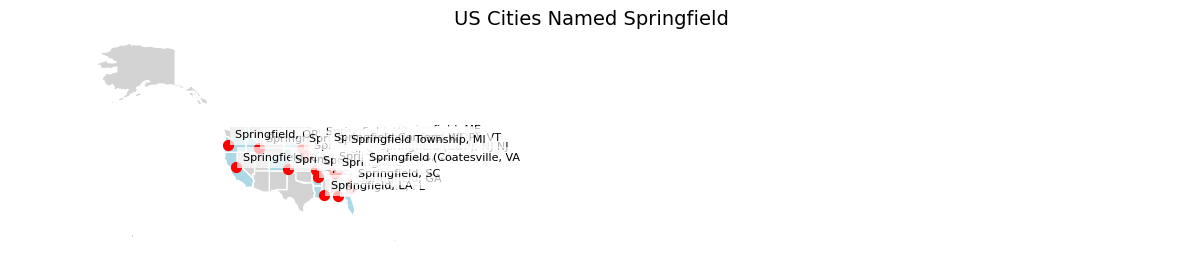

In [2]:
springfields_gdf = create_springfields_geodataframe()
    
# Perform spatial join with states
joined_gdf = join_springfields_to_states(springfields_gdf)
    
# Analyze distribution
state_counts = analyze_springfield_distribution(joined_gdf)

# Create and save map
fig, ax = plot_springfields(joined_gdf, save_path='figures/springfields_map.png')

The map looks very cramped. In order to make it more clear we might want to filter to the continental United States. Here is an example image when filtered correctly:

<img src="figures/springfields_map_example.png" alt="Springfields Map Example" />
